# YouTube Machine Learning Model
###### Created by Randhir and Andrew

Model that will take a $90\times120$ thumbnail JPEG and title from YouTube to output a video performance metric.
The metric will be 
$$Score=\log{(View\ Count + 1)}$$
The idea is that the video that attracted more views is a good video. The value is log-scaled as the higher the view count, the less meaningful it becomes. This value will be normalized with the maximum value in the dataset.

#### Imports
This cell contains all the necessary imports of the model.

In [2]:
import string, requests, os, json, random
import urllib.request
import urllib.error
from pathlib import Path

from langdetect import detect
from langdetect.lang_detect_exception import LangDetectException

import numpy as np
import pandas as pd

from PIL import Image

import tensorflow as tf
from tf_keras.backend import clear_session
from tf_keras.callbacks import ModelCheckpoint
from tf_keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, Concatenate, Input
from tf_keras.preprocessing.text import Tokenizer
from tf_keras.preprocessing.sequence import pad_sequences
from tf_keras.utils import Sequence, plot_model
from tf_keras import Model
from sklearn.model_selection import KFold
from transformers import TFBertModel, BertTokenizer

from dotenv import load_dotenv

# Load .env file with your api key
if not load_dotenv():
	print(".env file not found")

d:\OneDrive\OneDrive - University of Waterloo\School\Courses\4A\MSE 446\Project\YT-ML\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### Constants
This cell contains the constants used by this model

In [ ]:
# File Structure
dirpath = "thumbnail"
modeldir = "models"
datafile = "data-filtered.csv"

# Data Aquisition
filepath = "data.csv"
count = 50
max_iterations = 100 # 50 * 100 = 5000 videos
topic_id = "/m/03hf_rm" # Strategy Games
lang = "en"
API_KEY = os.getenv("APIKEY")

# Data Filtering
MULT_CSV = False
filepath = "data.csv"
filepath_2 = "data_2.csv"
filepath_final = "data-filtered.csv"
lang = "en"

# Labeling
MAX_VIEWS = 15.3e9 # Baby Shark Video (Most Viewed Video)
THRESHOLD = 0.4

# Vectorization
vectorizator_model = "bert-base-uncased"
bert_tokenizer = BertTokenizer.from_pretrained(vectorizator_model)
bert_model = TFBertModel.from_pretrained(vectorizator_model)
bert_model.trainable = False

# Text Model Settings
text_input_dim = 20000
embedding_dim = 128
sequence_length = 500

# KFold Settings
n_folds = 5
epochs = 10
batch_size = 30

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

#### Data Aquisition
The YouTube API is used to get video data. This includes a video's thumbnail and metrics.

In [ ]:
# Check if data file already exist
if os.path.isfile(filepath):
    df = pd.read_csv(filepath, index_col="yt-id")
else:
    df = pd.DataFrame([], columns=["yt-id", "title", "created", "channel-id", "thumbnail", "thumbnail-w", "thumbnail-h", "view-count", "like-count", "comment-count", "query"])
    df = df.set_index("yt-id")
    
# Grab missing data IDs for query
yt_ids = list(df[df["view-count"].isna()].index)

# Loop
yt_reads = 0
for i in range(max_iterations):
    try:
        # Check if any stats calls are needed
        if len(yt_ids) > 0:
            # Message 
            print("Pulling statistics for missing data values")

            # Split up batch by 50 if needed
            for index_split in range(50, len(yt_ids) + 1, 50):
                # Generate & call statistic query (1 unit)
                urlData_stats = f"https://www.googleapis.com/youtube/v3/videos?key={API_KEY}&part=statistics&id={','.join(yt_ids[index_split - 50:index_split])}"
                webURL_stats = urllib.request.urlopen(urlData_stats)
                raw_stats_data = webURL_stats.read()
                results_stats = json.loads(raw_stats_data.decode(webURL_stats.info().get_content_charset('utf-8')))

                # Process Stats Response
                for stats_data in results_stats["items"]:
                    try:
                        # Parse data
                        new_row = pd.DataFrame([{
                            "yt-id": stats_data['id'],
                            "view-count": stats_data['statistics']['viewCount'],
                            "like-count": stats_data['statistics']['likeCount'] if 'likeCount' in stats_data['statistics'] else "",
                            "comment-count": stats_data['statistics']['commentCount'] if 'commentCount' in stats_data['statistics'] else "",
                        },])
                        new_row = new_row.set_index("yt-id")

                        # Update main dataset
                        df.update(new_row)
                    except KeyError:
                        # Weird Entry
                        continue

            # Reset after used
            yt_ids = [] 

            # Message 
            print("Finished pulling statistics for current batch")

        # Message
        print(f"Pulling {count} random videos")

        # Generates random query for YT
        r_q = ''.join(random.choice(string.ascii_uppercase + string.digits) for _ in range(3))

        # Calls the API for search results (100 units)
        urlData_query = f"https://www.googleapis.com/youtube/v3/search?key={API_KEY}&maxResults={count}&part=snippet&type=video&relevanceLanguage={lang}&topicId={topic_id}&q={r_q}"
        webURL_query = urllib.request.urlopen(urlData_query)
        raw_vid_data = webURL_query.read()
        results_vids = json.loads(raw_vid_data.decode(webURL_query.info().get_content_charset('utf-8')))

        # Process Video Response
        for video_data in results_vids['items']:
            # Ignore Live and Upcoming Content (no ratings yet)
            if video_data['snippet']['liveBroadcastContent'] != "none":
                continue

            # Parse data
            try:
                new_row = pd.DataFrame([{
                    "yt-id": video_data['id']['videoId'],
                    "title": video_data['snippet']['title'],
                    "created": video_data['snippet']['publishedAt'],
                    "channel-id": video_data['snippet']['channelId'],
                    "thumbnail": video_data['snippet']['thumbnails']["default"]["url"],
                    "thumbnail-w": video_data['snippet']['thumbnails']["default"]["width"],
                    "thumbnail-h": video_data['snippet']['thumbnails']["default"]["height"],
                    "query": r_q,
                },])
                new_row = new_row.set_index("yt-id")

                try:
                    # Append
                    df = pd.concat([df, new_row], verify_integrity=True)

                    # Store your ids
                    yt_reads += 1

                    # Prepare id for stats query
                    yt_ids.append(video_data['id']['videoId'])
                except ValueError:
                    # Duplicate video detected
                    continue
            except KeyError:
                # Weird Entry
                continue

        # Update User
        print(f"API call #{i + 1} successfully")

        # Dumb Data to prevent loss every 5 runs
        if i % 5 == 0:
            df.to_csv(filepath)

    # ON API failure, quit and save
    except urllib.error.HTTPError:
        print("Latest API call failed. You are likely out of units. Try again tomorrow.")
        break
    
# Write to csv
df.to_csv(filepath)

# Termination
print(f"Was able to pull {yt_reads} rows")
del df

After aquiring the data, the thumbnail images need to be pulled as well.

#### Data Filtering
Some of the pulled data need to be filtered before usage. This includes potential duplicates and non english entries. 

In [ ]:
# Read Data
df = pd.read_csv(filepath, index_col="yt-id")

# Merge multiple if needed
if MULT_CSV:
	df_2 = pd.read_csv(filepath_2, index_col="yt-id")
	df = pd.concat([df, df_2])

print(f"{df.size} rows in data file")

# Remove duplicates
df = df[~df.index.duplicated(keep='first')]
print(f"{df.size} rows remaining after duplication filter")

# Remove non language
def lang_filter(row) -> bool:
	try:
		print(row["title"])
		return detect(row["title"]) == lang
	except LangDetectException:
		return False
	
df = df[df.apply(lang_filter, axis=1)]
print(f"{df.size} rows remaining after translation filter")

# Save Filtered Data
df.to_csv(filepath_final)
del df

#### Thumbnail Requesting
Once the dataset has been filtered, the thumbnails can now be pulled. Images that do not fit the $90\times120$ size or is corrupted will be rejected.

In [ ]:
# Grab data
df = pd.read_csv(filepath, index_col="yt-id")

# Make directory for image if not already
if not os.path.isdir(dirpath):
	os.mkdir(dirpath)

# Iterate thru dataframe and download
def grab_thumbnail(x : pd.Series):
	# Check if file exist
	filename = f'{dirpath}/{x.name}.jpg'
	if os.path.isfile(filename):
		print(f"Thumbnail already retrieved for {x.name}")
		return

	# Call file
	with open(filename, 'wb') as handle:
		print(f"Retrieving thumbnail for {x.name}")
		response = requests.get(x["thumbnail"], stream=True)

		# Fail request
		if not response.ok:
			print(f"Could not retrieve thumbnail for {x.name}")

		# Success save
		for block in response.iter_content(1024):
			if not block:
				break

			handle.write(block)

# Apply to all
df.apply(grab_thumbnail, axis=1)
del df

In [8]:
# Filter Images
files = [f for f in os.listdir(dirpath) if os.path.isfile(f"{dirpath}/{f}") and f.endswith(".jpg")]
image_ids = []
i = 0
for f in files:
	im = None
	try:
		im = Image.open(f"{dirpath}/{f}")

		if im.size != (120, 90):
			im.close()
			Path.unlink(f"{dirpath}/{f}")
			print(f"{f} deleted")
			continue

		im.close()
		im = None

		# Save valid indexes for filtering
		image_ids.append(f[:-4])
	except:
		# Close bad files
		if im is not None:
			im.close()
			im = None

		# Delete Bad Files
		Path.unlink(f"{dirpath}/{f}")
		print(f"{f} deleted")

	i += 1

02v-CVttnS0.jpg deleted
0EZUP5Vtemw.jpg deleted
4KlB4i4dEWU.jpg deleted
6JhUQpe-J6U.jpg deleted
bAHQy0QFUMI.jpg deleted
DcejDtVA4MU.jpg deleted
E0Hchyxwr4c.jpg deleted
ffLdLgSbpEc.jpg deleted
hstJLLvhYSM.jpg deleted
htE2M7shdfI.jpg deleted
JTwsU2dDpEg.jpg deleted
Lpnw6hMIu24.jpg deleted
Q9D-aQzRuU4.jpg deleted
RPoQZ_926hQ.jpg deleted
Sl2ueV8kRRU.jpg deleted
StkNJFSGksg.jpg deleted
tnAYVF1-q74.jpg deleted
VDg_U-n3t-I.jpg deleted
X82cgnMGeD8.jpg deleted
XO6KolPTH8U.jpg deleted
XY6Iw4kTOEI.jpg deleted
yQKNzY4HGGg.jpg deleted
ZBbw3WfcxN8.jpg deleted


#### Data Processing
This process involves text processing and image processing. This will involve text standardization and vectorization. For the image, it needs to be processed and normalized.

##### Import Data

In [4]:
raw_data = pd.read_csv(datafile, index_col="yt-id")

# Filter raw data for thumbnail only entries
thumbnail_ids = pd.Series([f[:-4] for f in os.listdir(dirpath) if os.path.isfile(f"{dirpath}/{f}") and f.endswith(".jpg")], dtype=str)
raw_data = raw_data.loc[thumbnail_ids]

raw_data.describe()

,thumbnail-w,thumbnail-h,view-count,like-count,comment-count
count,35734.0,35734.0,3.527600e+04,3.428900e+04,35006.000000
mean,120.0,90.0,9.287259e+04,2.304083e+03,115.992858
std,0.0,0.0,1.687911e+06,3.117386e+04,1640.940831
min,120.0,90.0,0.000000e+00,0.000000e+00,0.000000
25%,120.0,90.0,3.000000e+01,1.000000e+00,0.000000
50%,120.0,90.0,2.815000e+02,8.000000e+00,1.000000
75%,120.0,90.0,3.153250e+03,7.500000e+01,12.000000
max,120.0,90.0,2.232996e+08,2.686147e+06,146332.000000


##### Title Tokenization

In [5]:
# Title Processing
input_texts = bert_tokenizer(list(raw_data["title"]), padding=True, truncation=True, max_length=10, return_tensors="tf")

##### Score Generation

In [6]:
# Label Processing
scores = raw_data["view-count"] # Grab View Count
scores = scores.fillna(0.0) # Replace NaN with 0
scores = scores.map(lambda x : np.log10(x + 1)) # Log everything to make it less extreme
scores = scores.div(np.log10(MAX_VIEWS + 1)) # Normalized (+1 to prevent one)

scores.describe()

count    35734.000000
mean         0.251066
std          0.141486
min          0.000000
25%          0.142091
50%          0.237930
75%          0.341665
max          0.819749
Name: view-count, dtype: float64

In [7]:
# Boolean Label
b_scores = scores.map(lambda x : int(x >= THRESHOLD))

b_scores.describe()

count    35734.000000
mean         0.158281
std          0.365009
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: view-count, dtype: float64

#### Models
Commonly, the Sequential API is used to train a model. However, due to the need for more than one input, the Functional API must be employed.

##### Image-Only Model

Model: "img_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image_inputs (InputLayer)   [(None, 90, 120, 3)]      0         
                                                                 
 conv2d (Conv2D)             (None, 90, 120, 32)       2432      
                                                                 
 max_pooling2d (MaxPooling2  (None, 45, 60, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 45, 60, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 22, 30, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 22, 30, 128)       73

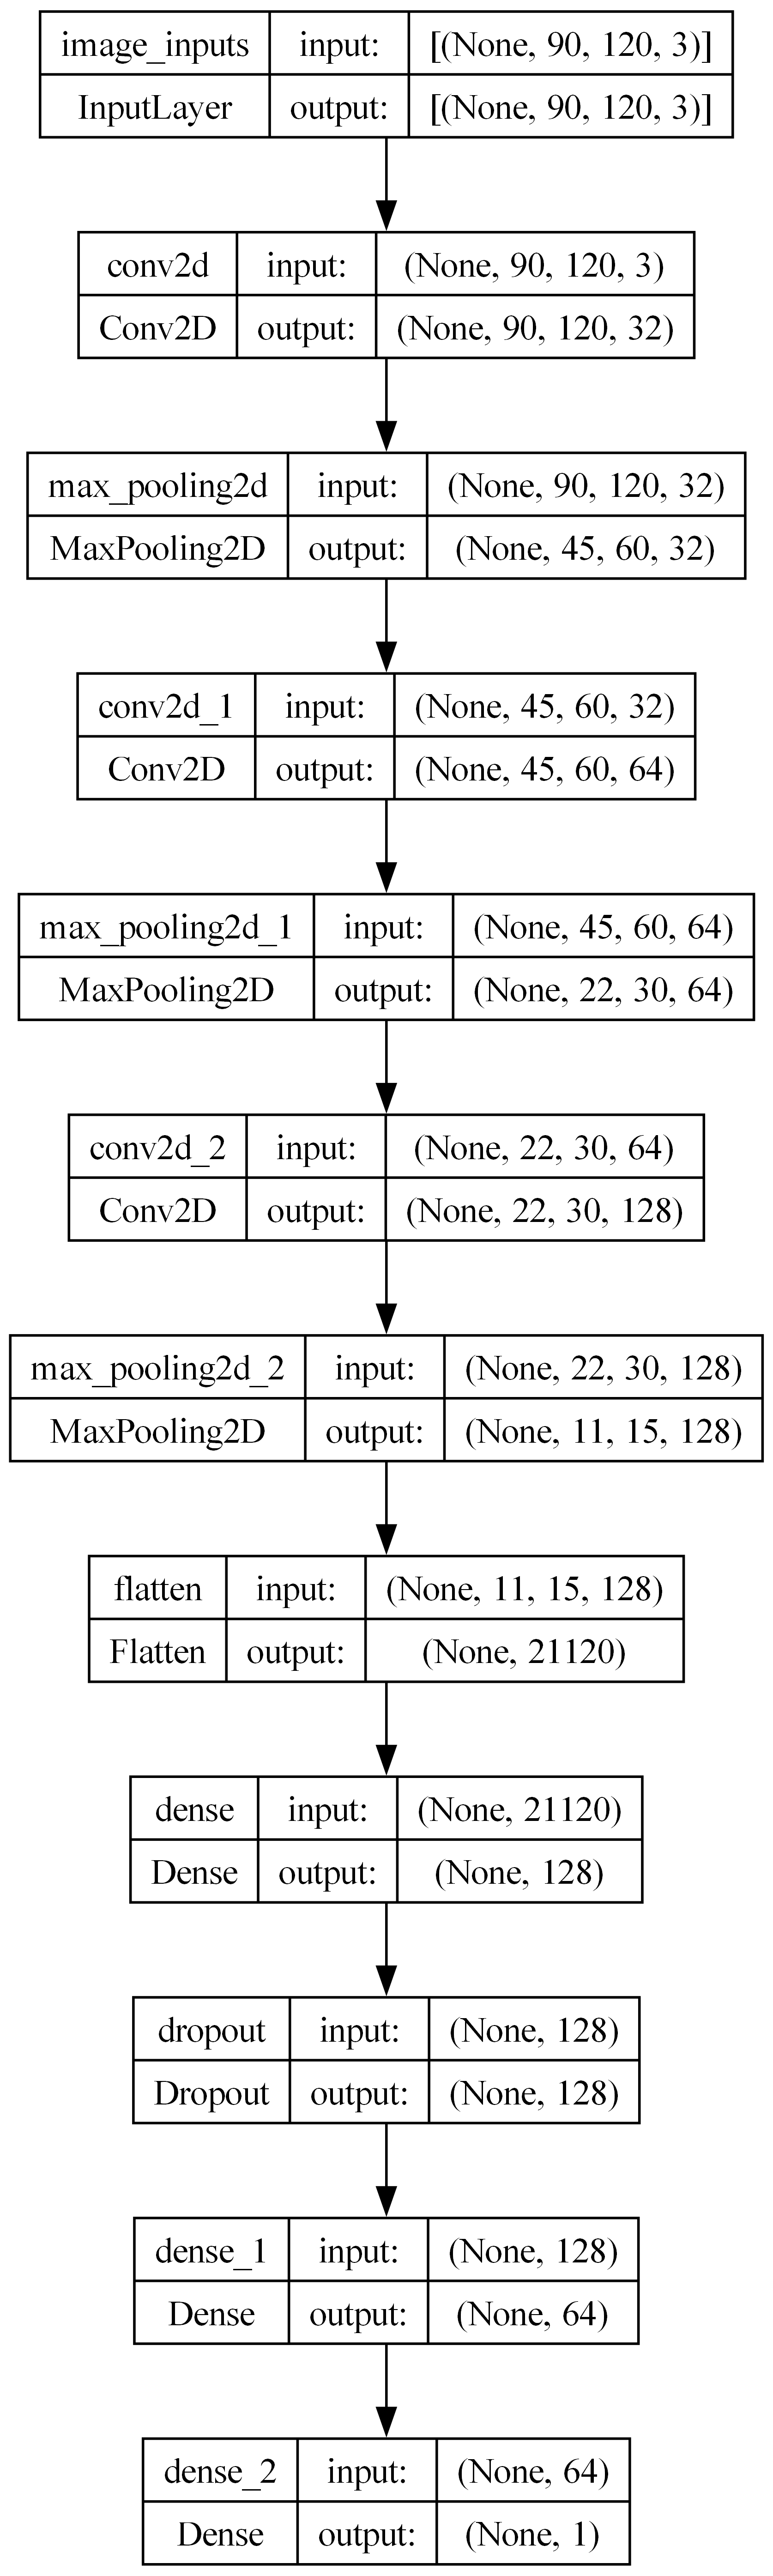

In [28]:
# Image Portion
img_input = Input((90, 120, 3), name="image_inputs")
x = Conv2D(32, 5, activation='relu', padding='same')(img_input)
x = MaxPooling2D()(x)
x = Conv2D(64, 3, activation='relu', padding='same')(x)
x = MaxPooling2D()(x)
x = Conv2D(128, 3, activation='relu', padding='same')(x)
x = MaxPooling2D()(x)
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x_out = Dropout(0.5)(x)
x_out = Dense(64, activation='relu')(x_out)
img_output = Dense(1, activation='sigmoid')(x_out)

img_model = Model(inputs=img_input, outputs=img_output, name="img_model")

img_model.summary()
plot_model(img_model, to_file='img_model.png', show_shapes=True, dpi=400)

##### Text-Only Model

Model: "text_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 text_inputs (InputLayer)    [(None, 10)]                 0         []                            
                                                                                                  
 attention_masks (InputLaye  [(None, 10)]                 0         []                            
 r)                                                                                               
                                                                                                  
 tf_bert_model (TFBertModel  TFBaseModelOutputWithPooli   1094822   ['text_inputs[0][0]',         
 )                           ngAndCrossAttentions(last_   40         'attention_masks[0][0]']     
                             hidden_state=(None, 10, 76                                  

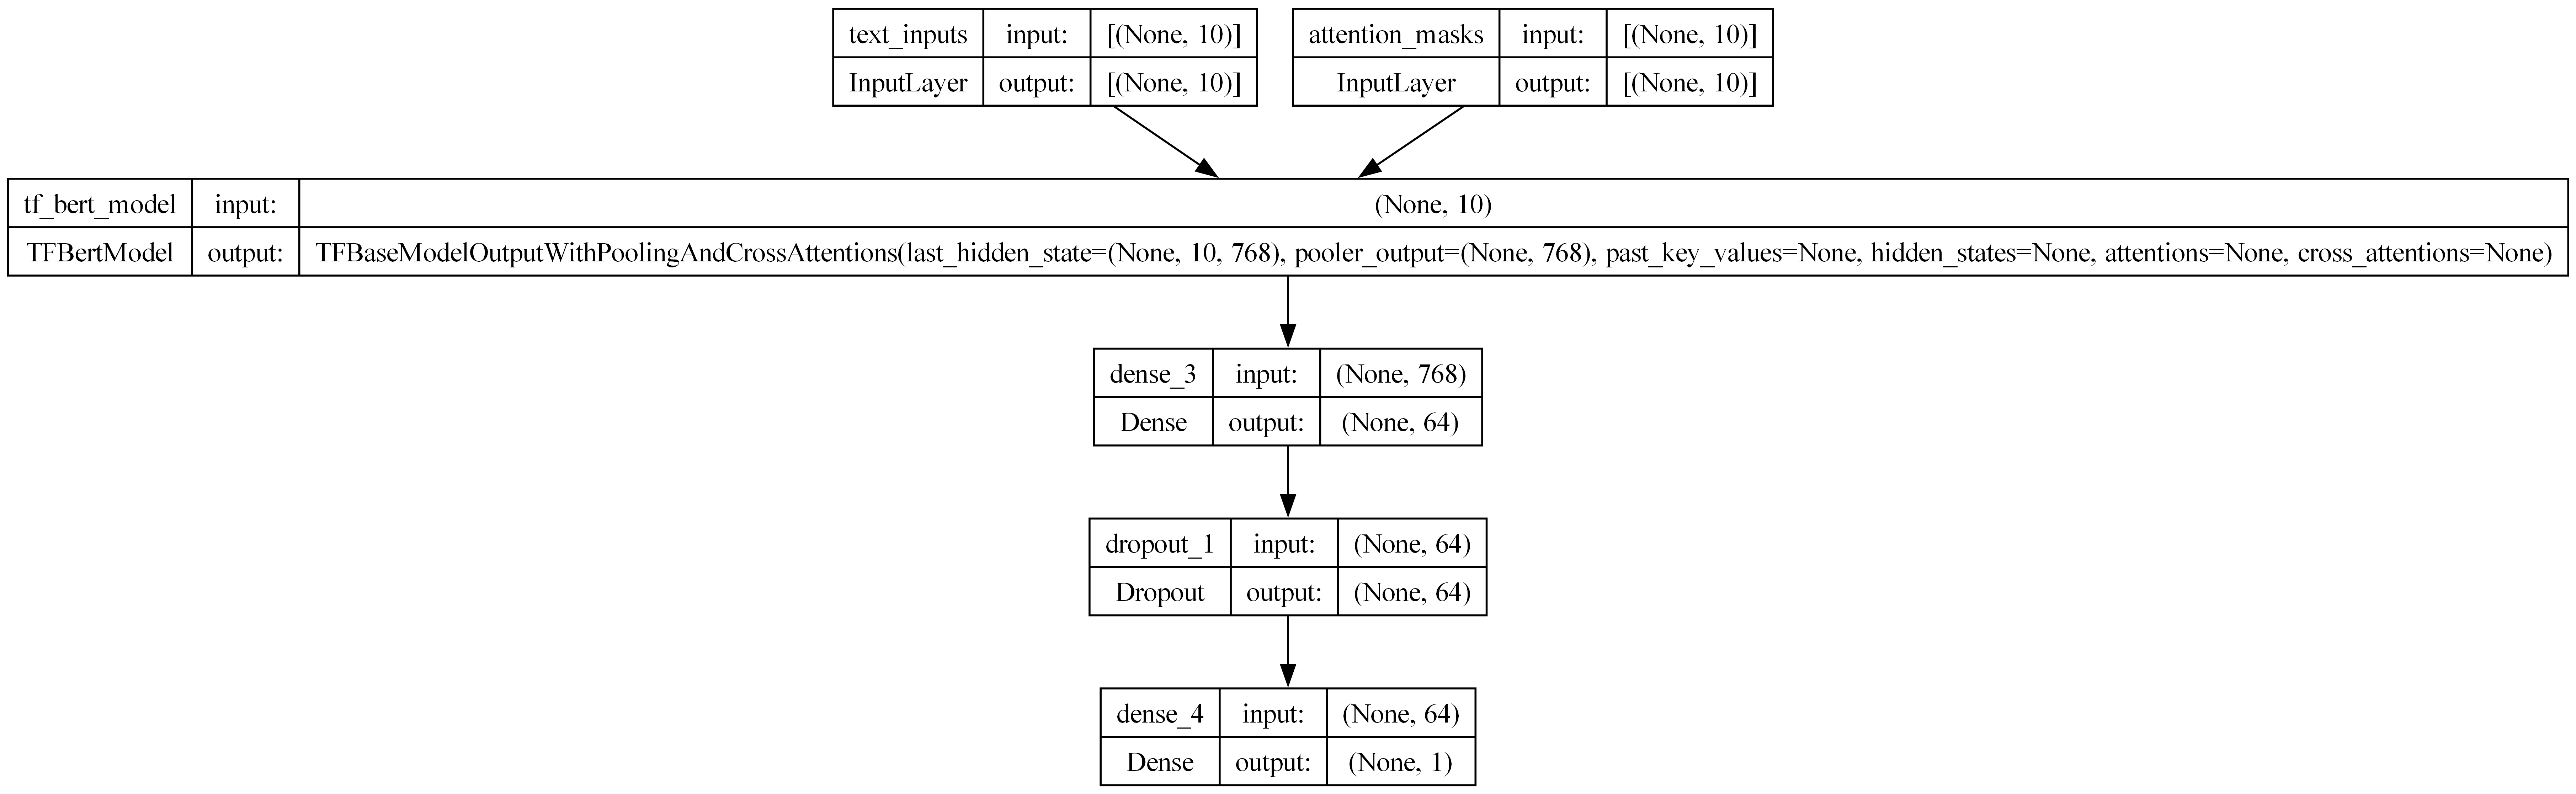

In [29]:
# Text Portion
text_input = Input(shape=(10,), dtype=tf.int32, name="text_inputs")
attention_mask = Input(shape=(10,), dtype=tf.int32, name="attention_masks")

transformer_output = bert_model(text_input, attention_mask=attention_mask)

# y = transformer_output.last_hidden_state[:, 0, :]
y = transformer_output.pooler_output

y = Dense(64, activation='relu')(y)
y_out = Dropout(0.5)(y)
text_output = Dense(1, activation='sigmoid')(y_out)

text_model = Model(inputs=[text_input, attention_mask], outputs=text_output, name="text_model")

text_model.summary()
plot_model(text_model, to_file='text_model.png', show_shapes=True, dpi=400)

##### United Model

In [30]:
# United Model
z = Concatenate()([x, y])
z = Dropout(0.5)(z)
z = Dense(32, activation='relu')(z)
z = Dense(1, activation='sigmoid')(z)

united_model = Model(inputs=[img_input, text_input, attention_mask], outputs=z, name="united_model")

united_model.summary()
plot_model(united_model, to_file='united_model.png', show_shapes=True, dpi=400)

Model: "united_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image_inputs (InputLayer)   [(None, 90, 120, 3)]         0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 90, 120, 32)          2432      ['image_inputs[0][0]']        
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 45, 60, 32)           0         ['conv2d[0][0]']              
 D)                                                                                               
                                                                                                  
 conv2d_1 (Conv2D)           (None, 45, 60, 64)           18496     ['max_pooling2d[0][

#### Generators
To lower memory usage, the dataset needs to be batched. This is done through the use of generators.

##### Thumbnail Data Generator
This generator is for the image-only model

In [14]:
class ThumbnailDataGenerator(Sequence):

	def __init__(self, 
			  filedir : str, 
			  list_IDs : pd.Series, 
			  labels : pd.Series, 
			  rescale : float=255.0, 
			  filetype : str="jpg", 
			  batch_size : int=32, 
			  dim : tuple[int, int]=(90, 120), 
			  shuffle=True
		):
		'''
		Data Generator Initialization Function 
		'''
		# File Location & Info
		self.filedir = filedir
		self.filetype = filetype

		# Image Settings
		self.dim = dim
		self.rescale = rescale

		# Batching
		self.batch_size = batch_size
		self.shuffle = shuffle

		# Datasets
		self.labels = labels
		self.list_IDs = list_IDs

		self.on_epoch_end()

	def on_epoch_end(self):
		'''
		Updates indexes after each epoch
		'''
		self.indexes = np.arange(len(self.list_IDs))

		# Randomize if Shuffle
		if self.shuffle:
			np.random.shuffle(self.indexes)

	def __data_generation(self, list_IDs_temp):
		'''
		Generates data containing batch_size samples
		'''
		# Initialization
		X = np.empty((self.batch_size, *self.dim, 3))
		y = np.empty((self.batch_size), dtype=float)

		# Generate data
		for i, ID in enumerate(list_IDs_temp):
			# Store sample
			X[i,] = Image.open(f'{self.filedir}/{ID}.{self.filetype}')

			# Store class
			y[i] = self.labels[ID]

		# Rescale
		X /= self.rescale

		return X, y
	
	def __len__(self):
		'''
		Denotes the number of batches per epoch
		'''
		return int(np.floor(len(self.list_IDs) / self.batch_size))
	
	def __getitem__(self, index):
		'''
		Generate one batch of data
		'''
		# Generate indexes of the batch
		indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

		# Find list of IDs
		list_IDs_temp = [self.list_IDs.iloc[k] for k in indexes]

		# Generate data
		return self.__data_generation(list_IDs_temp)

##### Thumbnail and Title Data Generator
The following generator is meant to handle both images and text inputs.

In [21]:
class ThumbnailTitleDataGenerator(Sequence):

	def __init__(self, 
			  filedir : str, 
			  list_IDs : pd.Series, 
			  texts : pd.Series, 
			  labels : pd.Series, 
			  rescale : float=255.0, 
			  filetype : str="jpg", 
			  batch_size : int=32, 
			  img_dim : tuple[int, int]=(90, 120), 
			  text_dim : int=10, 
			  tokenizer : BertTokenizer=None,
			  img_input_name : str="image_inputs",
			  text_input_name : str="text_inputs",
			  attention_input_name : str="attention_masks",
			  shuffle=True
		):
		'''
		Data Generator Initialization Function 
		'''
		# File Location & Info
		self.filedir = filedir
		self.filetype = filetype

		# Dimensions
		self.img_dim = img_dim
		self.text_dim = text_dim
		self.rescale = rescale

		# Batching
		self.batch_size = batch_size
		self.shuffle = shuffle

		# Datasets
		self.labels = labels
		self.list_IDs = list_IDs
		self.texts = texts
		self.tokenizer = tokenizer

		# Input Names
		self.img_input_name = img_input_name
		self.text_input_name = text_input_name
		self.attention_input_name = attention_input_name

		self.on_epoch_end()

	def on_epoch_end(self):
		'''
		Updates indexes after each epoch
		'''
		self.indexes = np.arange(len(self.list_IDs))

		# Randomize if Shuffle
		if self.shuffle:
			np.random.shuffle(self.indexes)

	def __data_generation(self, list_IDs_temp : list[str]):
		'''
		Generates data containing batch_size samples
		'''
		# Initialization
		X_IMG = np.empty((self.batch_size, *self.img_dim, 3))
		X_TEXT = np.empty((self.batch_size, self.text_dim))
		X_ATTENTION = np.empty((self.batch_size, self.text_dim))
		y = np.empty((self.batch_size), dtype=float)

		# Generate data
		temp_titles : list[str] = [None] * self.batch_size
		for i, ID in enumerate(list_IDs_temp):
			# Store sample
			X_IMG[i,] = Image.open(f'{self.filedir}/{ID}.{self.filetype}')

			# Process title
			temp_titles[i] = self.texts[ID]

			# Store class
			y[i] = self.labels[ID]

		# Rescale
		X_IMG /= self.rescale

		# Encode Text
		encoded_text = self.tokenizer(temp_titles, padding=True, truncation=True, max_length=self.text_dim)
		X_TEXT[:,:] = encoded_text["input_ids"]
		X_ATTENTION[:,:] = encoded_text["attention_mask"]

		# Unify Inputs
		X = {
			self.img_input_name: X_IMG,
			self.text_input_name: X_TEXT,
			self.attention_input_name: X_ATTENTION
		}

		return X, y
	
	def __len__(self):
		'''
		Denotes the number of batches per epoch
		'''
		return int(np.floor(len(self.list_IDs) / self.batch_size))
	
	def __getitem__(self, index):
		'''
		Generate one batch of data
		'''
		# Generate indexes of the batch
		indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

		# Find list of IDs
		list_IDs_temp = [self.list_IDs.iloc[k] for k in indexes]

		# Generate data
		return self.__data_generation(list_IDs_temp)

#### Training
Using k-fold cross validation, we can judge the accuarcy of this models. The models will undergo a k-fold cross validation.

##### Image-Only Training

In [26]:
# Image Model
kf = KFold(n_folds)

img_validation_accuracy = []
img_validation_loss = []

fold_var = 1
for train, val in kf.split(thumbnail_ids, b_scores):
	# Fold Indicator
	print(f"Starting k-Fold #{fold_var}")
	
	# Clear Keras
	clear_session()

	# Make image model for testing
	img_model = Model(inputs=img_input, outputs=img_output, name="img_model")
	img_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', 'Precision', 'Recall'])

	# Callback Saving
	checkpoint = ModelCheckpoint(f"{modeldir}/img-model_{fold_var}.h5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

	# Generator
	tbdg_train = ThumbnailDataGenerator(dirpath, thumbnail_ids.iloc[train], b_scores.iloc[train], batch_size=batch_size)
	tbdg_validate = ThumbnailDataGenerator(dirpath, thumbnail_ids.iloc[val], b_scores.iloc[val], batch_size=batch_size)

	# Fit
	history = img_model.fit(x=tbdg_train, validation_data=tbdg_validate, callbacks=[checkpoint], epochs=epochs)

	# Grab Results
	img_model.load_weights(f"{modeldir}/img-model_{fold_var}.h5")
	
	results = img_model.evaluate(x=tbdg_validate)
	results = dict(zip(img_model.metrics_names, results))
	
	img_validation_accuracy.append(results['accuracy'])
	img_validation_loss.append(results['loss'])

	# Increment
	fold_var += 1

Starting k-Fold #1
Epoch 1/5
952/952 [==============================] - ETA: 0s - loss: 0.4204 - accuracy: 0.8347 - precision: 0.1429 - recall: 0.0021
Epoch 1: val_accuracy improved from -inf to 0.86275, saving model to models\img-model_1.h5
952/952 [==============================] - 99s 102ms/step - loss: 0.4204 - accuracy: 0.8347 - precision: 0.1429 - recall: 0.0021 - val_loss: 0.3563 - val_accuracy: 0.8627 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/5
  1/952 [..............................] - ETA: 2:01 - loss: 0.3275 - accuracy: 0.9000 - precision: 0.0000e+00 - recall: 0.0000e+00

d:\OneDrive\OneDrive - University of Waterloo\School\Courses\4A\MSE 446\Project\YT-ML\.venv\Lib\site-packages\tf_keras\src\engine\training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


952/952 [==============================] - ETA: 0s - loss: 0.3987 - accuracy: 0.8365 - precision: 0.5000 - recall: 6.4254e-04
Epoch 2: val_accuracy did not improve from 0.86275
952/952 [==============================] - 96s 101ms/step - loss: 0.3987 - accuracy: 0.8365 - precision: 0.5000 - recall: 6.4254e-04 - val_loss: 0.3602 - val_accuracy: 0.8627 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/5
952/952 [==============================] - ETA: 0s - loss: 0.3912 - accuracy: 0.8360 - precision: 0.3571 - recall: 0.0043
Epoch 3: val_accuracy did not improve from 0.86275
952/952 [==============================] - 95s 100ms/step - loss: 0.3912 - accuracy: 0.8360 - precision: 0.3571 - recall: 0.0043 - val_loss: 0.3501 - val_accuracy: 0.8625 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/5
952/952 [==============================] - ETA: 0s - loss: 0.3882 - accuracy: 0.8355 - precision: 0.4364 - recall: 0.0206
Epoch 4: val_accuracy did not improve from 0.86275
952/9

##### Text-Only Training

In [27]:
# Text Model
kf = KFold(n_folds)

text_validation_accuracy = []
text_validation_loss = []

fold_var = 1
for train, val in kf.split(input_texts["input_ids"], b_scores):
	# Fold Indicator
	print(f"Starting k-Fold #{fold_var}")
	
	# Clear Keras
	clear_session()

	# Make image model for testing
	text_model = Model(inputs=[text_input, attention_mask], outputs=text_output, name="text_model")
	text_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

	# Callback Saving
	checkpoint = ModelCheckpoint(f"{modeldir}/text-model_{fold_var}.h5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

	# Train / Validation
	trainset = {
		"text_inputs": tf.gather(input_texts["input_ids"], indices=train), 
		"attention_masks": tf.gather(input_texts["attention_mask"], indices=train)
	}
	testset = {
		"text_inputs": tf.gather(input_texts["input_ids"], indices=val), 
		"attention_masks": tf.gather(input_texts["attention_mask"], indices=val)
	}

	# Fit
	history = text_model.fit(x=trainset, y=b_scores.iloc[train], validation_data=(testset, b_scores.iloc[val]), callbacks=[checkpoint], epochs=epochs)

	# Grab Results
	text_model.load_weights(f"{modeldir}/text-model_{fold_var}.h5")
	
	results = text_model.evaluate(x=testset, y=b_scores.iloc[val])
	results = dict(zip(text_model.metrics_names, results))
	
	text_validation_accuracy.append(results['accuracy'])
	text_validation_loss.append(results['loss'])

	# Increment
	fold_var += 1

Starting k-Fold #1
Epoch 1/5
894/894 [==============================] - ETA: 0s - loss: 0.4638 - accuracy: 0.8356
Epoch 1: val_accuracy improved from -inf to 0.86260, saving model to models\text-model_1.h5
894/894 [==============================] - 232s 248ms/step - loss: 0.4638 - accuracy: 0.8356 - val_loss: 0.3875 - val_accuracy: 0.8626
Epoch 2/5
894/894 [==============================] - ETA: 0s - loss: 0.4446 - accuracy: 0.8364
Epoch 2: val_accuracy did not improve from 0.86260
894/894 [==============================] - 225s 252ms/step - loss: 0.4446 - accuracy: 0.8364 - val_loss: 0.3817 - val_accuracy: 0.8626
Epoch 3/5
894/894 [==============================] - ETA: 0s - loss: 0.4399 - accuracy: 0.8364
Epoch 3: val_accuracy did not improve from 0.86260
894/894 [==============================] - 218s 244ms/step - loss: 0.4399 - accuracy: 0.8364 - val_loss: 0.3864 - val_accuracy: 0.8625
Epoch 4/5
894/894 [==============================] - ETA: 0s - loss: 0.4363 - accuracy: 0.8364
Ep

##### United Training

In [22]:
# United Model
kf = KFold(n_folds)

united_validation_accuracy = []
united_validation_loss = []

fold_var = 1
for train, val in kf.split(thumbnail_ids, b_scores):
	# Fold Indicator
	print(f"Starting k-Fold #{fold_var}")
	
	# Clear Keras
	clear_session()

	# Make image model for testing
	united_model = Model(inputs=[img_input, text_input, attention_mask], outputs=z, name="united_model")
	united_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', 'Precision', 'Recall'])

	# Callback Saving
	checkpoint = ModelCheckpoint(f"{modeldir}/complete-model_{fold_var}.h5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

	# Generator
	tbtdg_train = ThumbnailTitleDataGenerator(dirpath, thumbnail_ids.iloc[train], raw_data["title"].iloc[train], b_scores.iloc[train], batch_size=batch_size, tokenizer=bert_tokenizer)
	tbtdg_validate = ThumbnailTitleDataGenerator(dirpath, thumbnail_ids.iloc[val], raw_data["title"].iloc[val], b_scores.iloc[val], batch_size=batch_size, tokenizer=bert_tokenizer)

	# Fit
	history = united_model.fit(x=tbtdg_train, validation_data=tbtdg_validate, callbacks=[checkpoint], epochs=epochs)

	# Grab Results
	united_model.load_weights(f"{modeldir}/complete-model_{fold_var}.h5")
	
	results = united_model.evaluate(x=tbtdg_validate)
	results = dict(zip(united_model.metrics_names, results))
	
	united_validation_accuracy.append(results['accuracy'])
	united_validation_loss.append(results['loss'])

	# Increment
	fold_var += 1

Starting k-Fold #1
Epoch 1/5


952/952 [==============================] - ETA: 0s - loss: 0.4182 - accuracy: 0.8350 - precision: 0.2162 - recall: 0.0034
Epoch 1: val_accuracy improved from -inf to 0.86261, saving model to models\complete-model_1.h5


d:\OneDrive\OneDrive - University of Waterloo\School\Courses\4A\MSE 446\Project\YT-ML\.venv\Lib\site-packages\tf_keras\src\engine\training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


952/952 [==============================] - 829s 856ms/step - loss: 0.4182 - accuracy: 0.8350 - precision: 0.2162 - recall: 0.0034 - val_loss: 0.3420 - val_accuracy: 0.8626 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/5
952/952 [==============================] - ETA: 0s - loss: 0.3973 - accuracy: 0.8365 - precision: 0.5116 - recall: 0.0141
Epoch 2: val_accuracy improved from 0.86261 to 0.86317, saving model to models\complete-model_1.h5
952/952 [==============================] - 300s 315ms/step - loss: 0.3973 - accuracy: 0.8365 - precision: 0.5116 - recall: 0.0141 - val_loss: 0.3446 - val_accuracy: 0.8632 - val_precision: 0.5101 - val_recall: 0.1030
Epoch 3/5
952/952 [==============================] - ETA: 0s - loss: 0.3900 - accuracy: 0.8362 - precision: 0.4889 - recall: 0.0330
Epoch 3: val_accuracy did not improve from 0.86317
952/952 [==============================] - 286s 300ms/step - loss: 0.3900 - accuracy: 0.8362 - precision: 0.4889 - recall: 0.0330 - val_loss: 0.

##### Final Training
Once all the models have been trained and analysised with k-fold cross validation, the final model will be trained with all the data. It will then be tested with new data from the YouTube API.

In [ ]:
# Clear Keras
clear_session()

# Make image model for testing
united_model = Model(inputs=[img_input, text_input, attention_mask], outputs=z, name="final_united_model")
united_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', 'Precision', 'Recall'])

# Callback Saving
checkpoint = ModelCheckpoint(f"{modeldir}/final-complete-model_{fold_var}.h5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

# Generator
tbtdg_train = ThumbnailTitleDataGenerator(dirpath, thumbnail_ids, raw_data["title"], b_scores, batch_size=batch_size, tokenizer=bert_tokenizer)

# Fit
history = united_model.fit(x=tbtdg_train, callbacks=[checkpoint], epochs=epochs)